# Reproduce Paper: Efficient evolution of human antibodies from general protein language models
https://www-nature-com.sire.ub.edu/articles/s41587-023-01763-2

In [1]:
from transformers import AutoTokenizer, EsmForMaskedLM, pipeline
import torch
import pandas as pd
import itertools
from datasets import Dataset
import seaborn as sns

In [2]:
tokenizer_args = {}
tokenizer_args["padding"] = True
tokenizer_args["truncation"] = True

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model_name = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_name, **tokenizer_args)
model = EsmForMaskedLM.from_pretrained(model_name)

Using cpu device


In [7]:
protein_sequence = "MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPPPVRRIIGDLSNREKVLIGLDLLYEEIGDQAEDDLGLE"

In [19]:
def masked_marginal(positions, input_ids, tokenizer, model):
	all_prob = {}
	for x in positions:
		masked_input_ids = input_ids.clone()
  # The plus + makes sure we are assigning the correct positions to the correct index (since CLS is at the begining of teh position)
		masked_input_ids[0, x+1] = tokenizer.mask_token_id
		with torch.no_grad():
			output = model(masked_input_ids).logits # to remove the probabilities of the tokens [CLS] and [SEP]
		probabilities = torch.nn.functional.softmax(output[0, x+1], dim=0)
		all_prob[x] = torch.log(probabilities)
	return all_prob

def wild_marginal(positions, input_ids, tokenizer, model):
	all_prob = {}
	with torch.no_grad():
		output = model(input_ids).logits
	for x in positions:
     # softmaxing the probabilities of the correct positions -> so it is shape 33 the probabilities
		probabilities = torch.nn.functional.softmax(output[0, x+1], dim=0)
		all_prob[x] = torch.log(probabilities)
	return all_prob

def get_probabilities(protein_sequence, model, tokenizer, positions=(), 
                      strategy=masked_marginal):
    # Encode the protein sequence
    input_ids = tokenizer.encode(protein_sequence, return_tensors="pt") # it will add a cls and eos tokens, so the lenght is less 
    # sequence_length = input_ids.shape[1] - 2 
    # List of amino acids
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"
    if not isinstance(amino_acids, str):
        raise TypeError("amino_acids should be a string")
    aa_ids = {aa: tokenizer.convert_tokens_to_ids(aa) for aa in amino_acids}
    if not aa_ids:
        raise ValueError("Could not convert tokens to ids")
    prob_mt = {}
    # Get the probabilities	
    all_prob = strategy(positions, input_ids, tokenizer, model)
    if not all_prob:
        raise ValueError("Could not get the probabilities")
    if not positions:
        positions = range(input_ids.shape[1]-2) # -2 to remove the CLS and EOS tokens
        # This will get he probabilities of all the positions in the sequence
        
    for pos in positions:
        wt_residue_id = input_ids[0, pos+1].item()
        wt_token = tokenizer.convert_ids_to_tokens(wt_residue_id)
        # Get the probability of the wild type residue
        prob_wt = all_prob[pos][wt_residue_id].item()
        # Get the probability of the mutant residue relative to the wild type residue
        prob_mt[f"{wt_token}{pos}"] = {f"{key}": all_prob[pos][value].item() - prob_wt for key, value in aa_ids.items()}
    return pd.DataFrame(prob_mt).T

def filter_probabilities_by_alpha(probability, alpha):
	# Filter the probabilities
	filtered_prob = {}
	for pos, probs in probability.items():
		filtered_prob[pos] = {aa: prob for aa, prob in probs.items() if prob > alpha}
	return filtered_prob


def filter_probabilities_by_set(probability, aa_set):
	# Filter the probabilities
	filtered_prob = {}
	for aa in aa_set:
		print(aa)
		filtered_prob[aa[:2]] = {}
		for mut, probs in probability[aa[:2]].items():
			if mut == aa[-1]:
				filtered_prob[aa[:2]][mut] = probs
	return filtered_prob

def return_set(probabilities):
	# Return the set of the probabilities
	prob_set = []
	for prob in probabilities:
		proba = []
		for key, value in prob.items():
			proba.extend([f"{key}{k}" for k in value.keys()])
		prob_set.append(proba)
	prob = set(prob_set[0]).intersection(*prob_set[1:])
	return prob

def filter_by_k(probabilities, k):
	# Filter the probability based on how many models agree
	sets = list(itertools.combinations(probabilities, k))
	all_sets = [return_set(comb_probabilities) for comb_probabilities in sets]
	all_sets = all_sets[0].union(*all_sets[1:])
	new_probabilities = [filter_probabilities_by_set(prob, all_sets) for prob in probabilities]
	return new_probabilities


In [5]:
def count_vote(probabilities):
	# Return the set of the probabilities
	model_count = {}
	model_names = {}
	for model_name, prob in probabilities.items():
		for key, value in prob.items():
			aa = [f"{key}{k}" for k in value.keys()]
			for a in aa:
				if a in model_count:
					model_count[a] += 1
					model_names[a].append(model_name)
				else:
					model_count[a] = 0
					model_names[a] = []
	return model_count, model_names

In [8]:
input_ids = tokenizer.encode(protein_sequence, return_tensors="pt") # it will add a cls and eos tokens, so the lenght is less 
# sequence_length = input_ids.shape[1] - 2 
# List of amino acids
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
aa_ids = {aa: tokenizer.convert_tokens_to_ids(aa) for aa in amino_acids}
prob_mt = {}
positions = 2 # zero indexed
masked_input_ids = input_ids.clone()
masked_input_ids[0, positions + 1] = tokenizer.mask_token_id
with torch.no_grad():
    output = model(masked_input_ids).logits
probabilities = torch.nn.functional.softmax(output[0, positions+1], dim=0)
log_prob = torch.log(probabilities)
wt_residue_id = input_ids[0, positions+1].item()
wt_token = tokenizer.convert_ids_to_tokens(wt_residue_id)
# Get the probability of the wild type residue
prob_wt = log_prob[wt_residue_id].item()
# Get the probability of the mutant residue relative to the wild type residue
prob_mt[f"{wt_token}{positions}"] = {f"{key}": log_prob[value].item() - prob_wt 
                                for key, value in aa_ids.items()}

In [9]:
pro = pd.DataFrame(prob_mt).T
a = {"seq1": pro, "seq2": pro, "seq3": pro}
u = pd.concat(a)

In [10]:
dat = Dataset.from_dict({"protein_sequence": [protein_sequence, protein_sequence]})
tok = dat.map(lambda examples: tokenizer(examples["protein_sequence"], return_tensors="np"), batched=True)
tok.set_format(type="torch", columns=["input_ids", "attention_mask"])

Map: 100%|██████████| 2/2 [00:00<00:00, 534.03 examples/s]


In [11]:
model(tok["input_ids"][0:1])

MaskedLMOutput(loss=None, logits=tensor([[[ 15.9025,  -7.9200,  -6.1842,  ..., -15.5280, -15.7363,  -7.9188],
         [ -7.1896, -14.3157,  -6.5762,  ..., -15.7697, -16.0283, -14.3127],
         [-12.2040, -21.2587, -10.2861,  ..., -16.1563, -16.0720, -21.2514],
         ...,
         [-10.6266, -20.2872, -11.2484,  ..., -16.0865, -16.1106, -20.2918],
         [-11.1109, -19.5755, -10.0964,  ..., -16.1828, -16.2939, -19.5695],
         [ -6.5226,  -8.9746,  16.3361,  ..., -16.6106, -16.5153,  -9.0164]]],
       grad_fn=<AddBackward0>), hidden_states=None, attentions=None)

In [20]:
a = get_probabilities(protein_sequence, model, tokenizer, positions=range(0, 10))

In [24]:
a[a>0]

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
M0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.249405,NaN,NaN,NaN,NaN,NaN,NaN,0.300082,0.125866,NaN,NaN,NaN
P2,0.295405,NaN,0.606345,1.052300,NaN,NaN,NaN,0.174117,0.886781,0.083617,NaN,0.449907,NaN,NaN,NaN,0.748898,0.660977,0.073753,NaN,NaN
L3,0.648111,NaN,0.189710,0.733877,NaN,NaN,NaN,NaN,1.052003,NaN,NaN,NaN,0.776066,NaN,NaN,0.697228,0.669650,0.257574,NaN,NaN
R4,0.679773,NaN,0.872293,1.185394,NaN,0.432633,NaN,NaN,1.433574,0.211695,NaN,0.720788,1.464011,0.301461,NaN,1.198884,1.010109,0.255025,NaN,NaN
K5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T6,NaN,NaN,0.684088,0.950507,NaN,0.469521,NaN,NaN,0.876373,NaN,NaN,0.129810,0.615412,NaN,NaN,0.413907,NaN,NaN,NaN,NaN
Y7,1.043069,NaN,1.628400,2.099530,NaN,1.601515,0.17293,0.300105,2.390928,0.589779,NaN,1.279382,2.155662,1.030976,1.308511,1.432712,1.386070,0.820189,NaN,NaN
V8,NaN,NaN,0.621612,0.815924,NaN,NaN,NaN,NaN,0.902529,NaN,NaN,0.192710,0.709438,NaN,NaN,0.313684,0.670698,NaN,NaN,NaN
L9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.058832,NaN,NaN


In [16]:
import matplotlib.pyplot as plt

<Axes: >

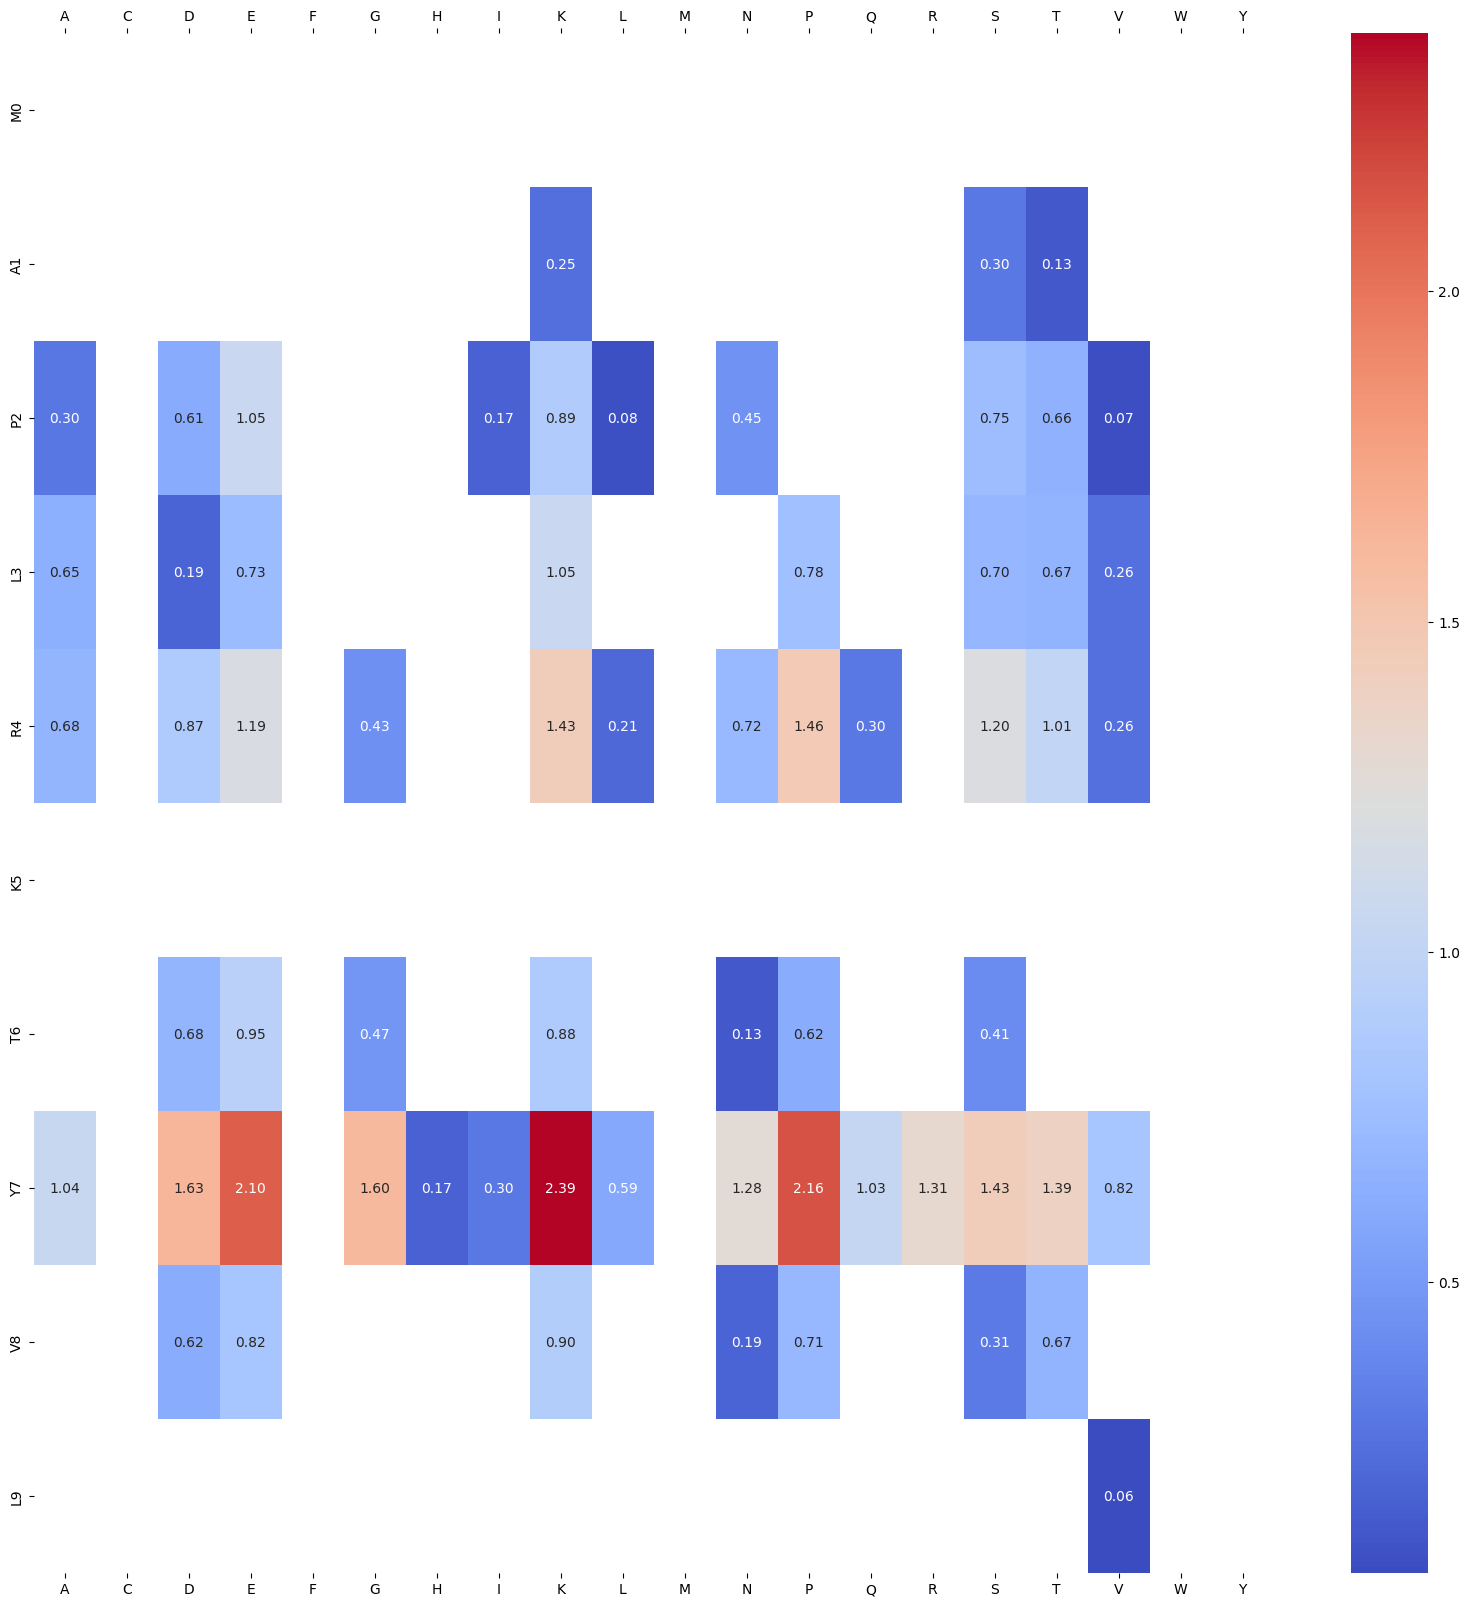

In [32]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.tick_params(axis='x', labelsize=10, labelbottom = True, bottom=True, top = True, labeltop=True)
sns.heatmap(a[a>0], annot=True, fmt=".2f", cmap="coolwarm")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = EsmForMaskedLM.from_pretrained(model_name)
# Encode the protein sequence
input_ids = tokenizer.encode(protein_sequence, return_tensors="pt") # it will add a cls and eos tokens, so the lenght is less 
# sequence_length = input_ids.shape[1] - 2 
# Get the probabilities	
with torch.no_grad():
    output = model(input_ids).logits[0,1:-1]

probabilities = torch.nn.functional.softmax(output, dim=1)
val = 0
for num, i in enumerate(input_ids[0,1:-1]):
    val += probabilities[num][i]
val.item()


75.0037612915039

In [83]:
torch.nn.functional.softmax(output, dim=1)[0]

tensor([1.7461e-07, 1.4035e-10, 3.2243e-07, 1.4058e-10, 1.7262e-04, 3.5684e-04,
        2.4192e-04, 2.5626e-04, 2.5007e-04, 2.7253e-04, 1.2750e-04, 2.4001e-04,
        1.3581e-04, 2.0171e-04, 5.6419e-04, 2.8589e-04, 1.1679e-04, 1.4464e-04,
        1.0539e-04, 7.0962e-05, 9.9636e-01, 4.8931e-05, 1.0774e-05, 1.4499e-05,
        1.7726e-05, 2.0059e-09, 1.5186e-09, 9.5016e-10, 4.3751e-11, 2.9994e-11,
        3.2791e-11, 2.5319e-11, 1.4077e-10])

In [35]:
output[0,1:-1]

torch.Size([108, 33])

In [28]:
torch.nn.functional.softmax(output[0, 1], dim=0)

tensor([1.7461e-07, 1.4035e-10, 3.2243e-07, 1.4058e-10, 1.7262e-04, 3.5684e-04,
        2.4192e-04, 2.5626e-04, 2.5007e-04, 2.7253e-04, 1.2750e-04, 2.4001e-04,
        1.3581e-04, 2.0171e-04, 5.6419e-04, 2.8589e-04, 1.1679e-04, 1.4464e-04,
        1.0539e-04, 7.0962e-05, 9.9636e-01, 4.8931e-05, 1.0774e-05, 1.4499e-05,
        1.7726e-05, 2.0059e-09, 1.5186e-09, 9.5016e-10, 4.3751e-11, 2.9994e-11,
        3.2791e-11, 2.5319e-11, 1.4077e-10])

In [ ]:
def wild_marginal(positions, input_ids, tokenizer, model):
	all_prob = []
	with torch.no_grad():
		output = model(input_ids).logits
	for x in positions:
		probabilities = torch.nn.functional.softmax(output[0, x+1], dim=0)
		all_prob.append(probabilities)
	return all_prob

In [30]:
input_ids = tokenizer.encode(protein_sequence, return_tensors="pt") # it will add a cls and eos tokens, so the lenght is less 
tokenizer.decode(input_ids[0])

'E'

In [36]:

sequence_length = input_ids.shape[1] - 2 
# List of amino acids
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
aa_ids = {aa: tokenizer.convert_tokens_to_ids(aa) for aa in amino_acids}
masked_input_ids = input_ids.clone()
masked_input_ids[0,56] = tokenizer.mask_token_id
with torch.no_grad():
    output = model(masked_input_ids).logits
    newoutput = model(input_ids).logits

In [64]:
all_prob = []
for x in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
	masked_input_ids = input_ids.clone()
	masked_input_ids[0, x+1] = tokenizer.mask_token_id
	with torch.no_grad():
		output = model(masked_input_ids).logits
	wt_residue_id = input_ids[0, x+1].item()
	wt_token = tokenizer.convert_ids_to_tokens(wt_residue_id)
	# Get the probability of the wild type residue
	probabilities = torch.nn.functional.softmax(output[0, x+1], dim=-1)
	all_prob.append(probabilities)


In [74]:
torch.stack(all_prob)[0]

tensor([1.2098e-07, 5.5431e-12, 5.2519e-07, 5.5082e-12, 4.9137e-02, 9.3152e-02,
        2.7678e-02, 4.3878e-02, 1.2575e-01, 7.7442e-02, 3.1851e-02, 1.0565e-01,
        5.8779e-02, 5.1997e-02, 6.2361e-02, 1.1954e-01, 3.1374e-02, 7.0313e-02,
        1.3865e-02, 1.0678e-02, 1.0953e-02, 1.1653e-02, 1.4777e-03, 2.3821e-03,
        8.9663e-05, 2.6679e-07, 1.8436e-07, 9.9049e-08, 2.9584e-09, 2.1299e-09,
        2.2080e-09, 2.2518e-09, 5.5910e-12])

In [46]:
probabilities = torch.nn.functional.softmax(output[0, 56], dim=0)
log_probabilities = torch.log(probabilities)
log_probabilities

tensor([-16.7804, -27.3554, -15.7982, -27.3520,  -1.4277,  -2.5076,  -3.9805,
         -1.9887,  -4.3450,  -3.8944,  -3.6909,  -4.1550,  -1.9134,  -4.8577,
         -4.9729,  -3.4737,  -4.2161,  -4.5330,  -2.4678,  -2.4993,  -3.5960,
         -4.5091,  -3.9432,  -5.1766, -11.6180, -15.6090, -15.8708, -16.4083,
        -19.7412, -20.0578, -20.1161, -20.1449, -27.3477])

In [48]:
probabilities.shape

torch.Size([33])

In [42]:
wt_residue = input_ids[0, 56].item()

log_prob_wt = log_probabilities[wt_residue].item()

In [59]:
for i, amino_acid in enumerate(amino_acids):
    log_prob_mt = log_probabilities[tokenizer.convert_tokens_to_ids(amino_acid)].item()
    u = log_prob_mt - log_prob_wt
    print(f"{amino_acid}: {u:.2f}")

A: 1.39
C: -1.28
D: -0.96
E: 0.00
F: 1.43
G: -0.09
H: -0.61
I: 1.98
K: 0.42
L: 2.47
M: 0.30
N: -0.64
P: -1.08
Q: -0.32
R: 0.20
S: -0.45
T: -0.26
V: 1.91
W: -0.05
Y: 1.40


In [53]:
prob_wt = probabilities[wt_residue].item()
# Get the probability of the mutant residue
prob_mt = {f"E56{key}": probabilities[value].item()/prob_wt for key, value in aa_ids.items()}
prob_mt

{'E56A': 4.001879542035948,
 'E56C': 0.2774215940895632,
 'E56D': 0.38165176240465715,
 'E56E': 1.0,
 'E56F': 4.164444006026979,
 'E56G': 0.9174956996554051,
 'E56H': 0.5408050497639408,
 'E56I': 7.24976954106049,
 'E56K': 1.5230791107844535,
 'E56L': 11.783465044635921,
 'E56M': 1.3477541668824693,
 'E56N': 0.5280566944547288,
 'E56P': 0.34012259939748507,
 'E56Q': 0.7249081595733019,
 'E56R': 1.2257103964296387,
 'E56S': 0.6372239090923898,
 'E56T': 0.770610221597457,
 'E56V': 6.724243731397887,
 'E56W': 0.9524152847213364,
 'E56Y': 4.035606249303408}

In [91]:
prob_mt["E56L"] / prob_mt["E56I"]

1.625357189342083

In [117]:
pipe = pipeline(task="fill-mask", model=model_name, tokenizer=model_name, top_k=20)

def use_pipe_marginal(pipe, sequence, positions, tokenizer):
	seq = []
	for pos in positions:
		sequence = sequence[:pos] + tokenizer.mask_token + sequence[pos+1:]
		seq.append(sequence)
	return pipe(seq)


def parse_pipe_output(output, sequence, positions):
	all_proba = {}
	for num, pos in enumerate(positions):
		wild = sequence[pos]
		all_proba[f"{wild}{pos}"] = {x["token_str"]: x["score"] for x in output[num]}
		all_proba[f"{wild}{pos}"] = {k: v / all_proba[f"{wild}{pos}"][wild] for k, v in all_proba[f"{wild}{pos}"].items()}
	return pd.DataFrame(all_proba).T

In [107]:
get_probabilities(protein_sequence, model, tokenizer, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
A2,1.000000,0.025572,0.558195,0.831349,0.148847,0.297127,0.125095,0.630997,1.283265,0.527495,0.117577,0.754814,0.669457,0.336804,0.341929,1.349972,1.134131,0.471038,0.015863,0.114632
P3,1.343673,0.057835,1.833724,2.864244,0.384301,0.914949,0.254400,1.190197,2.427309,1.087215,0.193616,1.568169,1.000000,0.777088,0.730884,2.114671,1.936685,1.076543,0.049764,0.326103
L4,1.911923,0.046710,1.208896,2.083139,0.208951,0.732715,0.219586,0.899000,2.863380,1.000000,0.117386,0.897115,2.172903,0.915103,0.794621,2.008179,1.953554,1.293787,0.032136,0.188638
R5,1.973429,0.095662,2.392388,3.271975,0.326470,1.541312,0.364618,0.966675,4.193666,1.235769,0.193045,2.056053,4.323272,1.351832,1.000000,3.316411,2.745901,1.290495,0.044551,0.291857
K6,0.276130,0.030226,0.507187,0.579249,0.063158,0.641203,0.093900,0.119002,1.000000,0.173978,0.045722,0.484264,0.732273,0.255497,0.316409,0.588060,0.392850,0.151816,0.012046,0.076425
T7,0.819319,0.061215,1.981964,2.587020,0.171343,1.599228,0.271671,0.415586,2.402177,0.486920,0.107403,1.138613,1.850421,0.620420,0.794016,1.512719,1.000000,0.601088,0.026687,0.223367
Y8,2.837910,0.146315,5.095696,8.162321,0.599036,4.960533,1.188780,1.350002,10.923614,1.803590,0.455732,3.594403,8.633596,2.803796,3.700657,4.190033,3.999094,2.270931,0.094145,1.000000
V9,0.783819,0.054291,1.861931,2.261264,0.269974,0.834610,0.400744,0.695419,2.465827,0.901744,0.134310,1.212532,2.032843,0.808421,0.995437,1.368458,1.955604,1.000000,0.056016,0.372498
L10,0.292952,0.040045,0.059589,0.082817,0.258523,0.148658,0.027128,0.820341,0.107850,1.000000,0.101818,0.053985,0.214230,0.035702,0.057471,0.073047,0.139872,1.060600,0.025686,0.128020
K11,0.686631,0.093666,1.227909,2.135774,0.138714,0.770501,0.386378,0.418194,1.000000,0.459316,0.087919,0.490002,0.130282,0.345678,0.529347,0.699894,1.421845,0.921015,0.035992,0.310612


In [118]:
use = use_pipe(pipe, protein_sequence, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], tokenizer)
parse_pipe_output(use, protein_sequence, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

,S,K,T,A,E,N,P,I,D,L,V,R,Q,G,F,H,M,Y,C,W
A1,1.349972,1.283265,1.134131,1.000000,0.831349,0.754814,0.669457,0.630997,0.558195,0.527495,0.471038,0.341929,0.336804,0.297127,0.148847,0.125095,0.117577,0.114632,0.025572,0.015863
P2,1.565557,1.799515,1.286391,0.988343,1.253368,1.099248,1.000000,1.043457,0.891353,1.304214,0.764856,0.858806,0.642436,0.888907,0.555891,0.334455,0.173488,0.455629,0.209028,0.141089
L3,1.200384,1.379770,0.986334,0.757808,0.961014,0.842844,0.766746,0.800066,0.683441,1.000000,0.586450,0.658485,0.492585,0.681566,0.426227,0.256442,0.133021,0.349352,0.160271,0.108179
R4,1.822947,2.095370,1.497883,1.150835,1.459431,1.279974,1.164408,1.215010,1.037898,1.518637,0.890605,1.000000,0.748057,1.035051,0.647284,0.389442,0.202011,0.530538,0.243394,0.164285
K5,0.869988,1.000000,0.714854,0.549228,0.696503,0.610858,0.555705,0.579855,0.495330,0.724758,0.425035,0.477243,0.357005,0.493970,0.308912,0.185858,0.096408,0.253196,0.116158,0.078404
T6,1.217015,1.398887,1.000000,0.768307,0.974329,0.854522,0.777369,0.811151,0.692910,1.013855,0.594576,0.667609,0.499410,0.691009,0.432132,0.259995,0.134864,0.354192,0.162492,0.109678
Y7,3.436032,3.949515,2.823327,2.169183,2.750849,2.412593,2.194766,2.290144,1.956311,2.862444,1.678681,1.884877,1.409996,1.950943,1.220051,0.734051,0.380766,1.000000,0.458767,0.309657
V8,2.046864,2.352749,1.681872,1.292195,1.638697,1.437196,1.307435,1.364252,1.165386,1.705174,1.000000,1.122832,0.839943,1.162188,0.726791,0.437278,0.226824,0.595706,0.273290,0.184465
L9,1.200384,1.379770,0.986334,0.757808,0.961014,0.842844,0.766746,0.800066,0.683441,1.000000,0.586450,0.658485,0.492585,0.681566,0.426227,0.256442,0.133021,0.349352,0.160271,0.108179
K10,0.869988,1.000000,0.714854,0.549228,0.696503,0.610858,0.555705,0.579855,0.495330,0.724758,0.425035,0.477243,0.357005,0.493970,0.308912,0.185858,0.096408,0.253196,0.116158,0.078404


In [110]:
res = pipe(protein_sequence[:55] + tokenizer.mask_token + protein_sequence[56:], top_k=20)
res[0]

{'score': 0.2398565262556076,
 'token': 4,
 'token_str': 'L',
 'sequence': 'M A P L R K T Y V L K L Y V A G N T P N S V R A L K T L N N I L E K E F K G V Y A L K V I D V L K N P Q L A E L D K I L A T P T L A K V L P P P V R R I I G D L S N R E K V L I G L D L L Y E E I G D Q A E D D L G L E'}